In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment

In [20]:
soundfiles = glob.glob('./**/*.sph', recursive = True)
#annofiles = glob.glob('./**/*.txt', recursive = True) + glob.glob('./**/*.sgml', recursive = True)
data = {}
for soundfile in soundfiles:
    name = soundfile.split('/')[-1].split('.')[0]
    annofile = glob.glob('./**/'+name+'*', recursive = True)
    if annofile[0] == soundfile:
        annofile = annofile[1]
    else:
        annofile = annofile[0]
    data[soundfile] = annofile
start_load = time.time()
sph =SPHFile(soundfiles[0])
junk, sr = sph.content, sph.format['sample_rate']
print(time.time()-start_load)

0.1053619384765625


In [24]:
seg = audiosegment.from_numpy_array(junk, sr)

silences = pydub.silence.detect_silence(seg, min_silence_len = 1000, silence_thresh=-32, seek_step = 30)
print(sum([b-a for [a, b] in silences]))
print(silences[-1])
print(len(seg))
ipd.Audio(data = np.concatenate([junk[int(a/1000*sr):int(b/1000*sr)] for [a,b] in silences]), rate = sr)
#ipd.Audio(data = seg, rate = sr)


49960
[1762440, 1764850]
1800000


In [65]:
annofile = data[soundfiles[0]]
doc = parse(annofile)
for tag in doc.getroot().iter():
    if tag.tag == 'segment':
        pass
        print(tag.attrib, tag.text)
tags = [item for item in doc.getroot().iter() if item.tag == 'segment']
segment_idx = np.random.randint(0, len(tags))
example_tag = tags[segment_idx]
start, end = example_tag.attrib['s_time'], example_tag.attrib['e_time']
print(start, end, example_tag.text_content(), example_tag.attrib['speaker'])
end = int(float(end)*sr)
start = max(end-2*sr, int(float(start)*sr))
sound_segment = junk[start:end]/(2**15)
ipd.Audio(data = sound_segment, rate = sr)

{'s_time': '0.000', 'e_time': '17.673', 'speaker': 'Lou_Waters', 'fidelity': 'High', 'mode': 'Planned'} 
{breath} the federal aviation administration clamps down on ValuJet as
investigators find more victims

{'s_time': '17.673', 'e_time': '20.920', 'speaker': 'male_native1', 'fidelity': 'Low', 'mode': 'Spontaneous'} 
a no hitter for dwight gooden

{'s_time': '20.920', 'e_time': '27.189', 'speaker': 'Lou_Waters', 'fidelity': 'High', 'mode': 'Planned'} 
and a troubled big leaguer shows he has more than a few good moves left

{'s_time': '32.274', 'e_time': '35.727', 'speaker': 'Lou_Waters', 'fidelity': 'High', 'mode': 'Planned'} 
and early prime begins a little bit late today I'm lou waters {breath}

{'s_time': '35.727', 'e_time': '38.203', 'speaker': 'Joie_Chen', 'fidelity': 'High', 'mode': 'Planned'} 
hello I'm Joie chen in today for natalie allen

{'s_time': '38.203', 'e_time': '79.821', 'speaker': 'Joie_Chen', 'fidelity': 'High', 'mode': 'Planned'} 
{breath} a search for answers and 

In [39]:
speaker_segments = {}
for soundfile in soundfiles:
    #sph = SPHFile(soundfile)
    #y, sr = sph.content, sph.format['sample_rate']
    annofile = data[soundfile]
    doc = parse(annofile)
    for tag in doc.getroot().iter():
        if tag.tag == 'segment':
            start, end, speaker = float(tag.attrib['s_time']), float(tag.attrib['e_time']), tag.attrib['speaker']
            if end-start<2:
                continue
            if speaker[0] == speaker[0].lower() or speaker.count('_')>1: # throw away non-reporters
                continue
            if speaker not in speaker_segments:
                speaker_segments[speaker] = []
            speaker_segments[speaker].append({'file': soundfile, 'start': start, 'end': end})
speaker_segments_truncated = {}
for key in speaker_segments.keys():
    if len(speaker_segments[key])>12:
        speaker_segments_truncated[key] = speaker_segments[key]
speaker_segments = speaker_segments_truncated

In [40]:
len(speaker_segments.keys())

189

In [41]:
S = librosa.feature.melspectrogram(sound_segment, n_mels = 128, n_fft = 551, hop_length = 220) # 25 ms window, 10 ms hop
S_dB = librosa.power_to_db(S, ref=np.max)[:, -200:]
print(S_dB.shape)

(128, 146)


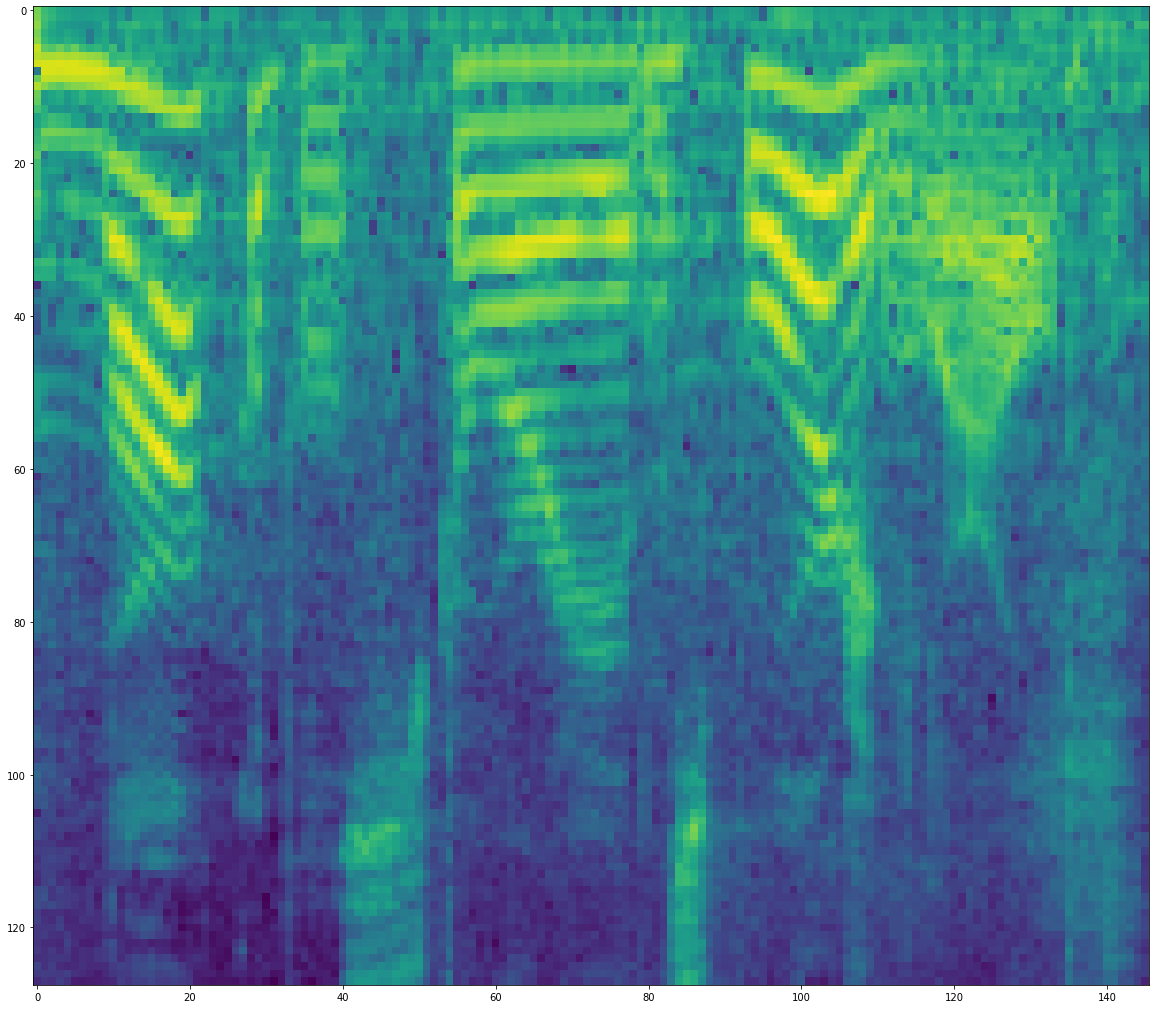

In [42]:
plt.figure(figsize = (20, 30))
plt.imshow(S_dB)

In [43]:
class SoundDataSet(Dataset):

    def __init__(self):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        soundfiles = glob.glob('./**/*.sph', recursive = True)
        annomap = {}
        for soundfile in soundfiles:
            name = soundfile.split('/')[-1].split('.')[0]
            annofile = glob.glob('./**/'+name+'*', recursive = True)
            if annofile[0] == soundfile:
                annofile = annofile[1]
            else:
                annofile = annofile[0]
            annomap[soundfile] = annofile
        self.soundfiles = soundfiles
        self.annomap = annomap
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sph = SPHFile(self.soundfiles[idx])
        sound, sr = sph.content, sph.format['sample_rate']
        annofile = annomap[soundfiles[idx]]
        doc = parse(annofile)
        tags = [item for item in doc.getroot().iter() if item.tag == 'segment']
        segment_idx = np.random.randint(0, len(tags))
        example_tag = tags[segment_idx]
        start, end = example_tag.attrib['s_time'], example_tag.attrib['e_time']
        print(start, end, example_tag.text_content(), example_tag.attrib['speaker'])
        end = int(float(end)*sr)
        start = max(end-2*sr, int(float(start)*sr))
        sound_segment = junk[start:end]
        ipd.Audio(data = sound_segment, rate = sr)

        return sample

NameError: name 'Dataset' is not defined

In [44]:
class Spectral_Attention(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Spectral_Attention, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell = nn.LSTM(input_size, hidden_size, num_layers, batch_first = False)
        self.attention = nn.Linear(hidden_size*num_layers, input_size) # can replace this with better attention mechanism
    def zero_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda(),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda())
    def forward(self, X, prev_state = None, mask = None): # X: (sequence length, batch, hidden size)
        batch_size = X.shape[1]
        if prev_state == None: # if we don't initialize hidden state
            prev_state = self.zero_state(batch_size)
        if mask == None:
            mask = torch.ones(batch_size, self.input_size).cuda()
        outputs = []
        for t, x in enumerate(X):
            x = x*mask
            x = x[None, ...] # 1, batch, hidden_size
            output, (state_h, state_c) = self.cell(x, prev_state)
            prev_state = (state_h, state_c)
            state_h = state_h.view(batch_size, -1)
            mask = self.attention(state_h)
            outputs.append(output)
        outputs = torch.cat(outputs, dim = 0)
        return outputs

In [45]:
# runtime test
X = S_dB[None, ...]
X = torch.Tensor(X).permute((0, 2, 1)).cuda()
print(X.shape)
dummy = nn.LSTM(128, 512, 3, batch_first = False).cuda()
net = Spectral_Attention(128, 512, 3).cuda()
loss = torch.nn.MSELoss(size_average=512, reduce=None, reduction='mean')
optim1 = torch.optim.Adam(dummy.parameters())
optim2 = torch.optim.Adam(net.parameters())
target = torch.zeros(200, 1, 512).cuda()

begin = time.time()
out1, state = dummy(X)
loss1 = loss(out1, target)
loss1.backward()
optim1.step()
print(time.time()-begin)

begin = time.time()
out2 = net(X)
loss2 = loss(out2, target)
loss2.backward()
optim2.step()
print(time.time()-begin)


torch.Size([1, 146, 128])
0.0274050235748291
0.009101152420043945


/home/joseph/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/joseph/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([200, 1, 512])) that is different to the input size (torch.Size([1, 146, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [363]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels//4, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels//4, output_channels//4, 3, stride, padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels//4)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels//4, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
        
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

class AttentionModule_stage1(nn.Module):
    # input size is 56*56
    def __init__(self, in_channels, out_channels, size1=(200, 128), size2=(100, 64), size3=(50, 32)):
        super(AttentionModule_stage1, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax1_blocks = ResidualBlock(in_channels, out_channels)

        self.skip1_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax2_blocks = ResidualBlock(in_channels, out_channels)

        self.skip2_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax3_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )

        self.interpolation3 = nn.UpsamplingBilinear2d(size=size3)

        self.softmax4_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)

        self.softmax5_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)

        self.softmax6_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        batch_size, nheads, length, n_mels = x.shape
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x)
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        out_mpool2 = self.mpool2(out_softmax1)
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
        out_mpool3 = self.mpool3(out_softmax2)
        out_softmax3 = self.softmax3_blocks(out_mpool3)
        #
        out_interp3 = self.interpolation3(out_softmax3) + out_softmax2
        # print(out_skip2_connection.data)
        # print(out_interp3.data)
        out = out_interp3 + out_skip2_connection
        out_softmax4 = self.softmax4_blocks(out)
        out_interp2 = self.interpolation2(out_softmax4) + out_softmax1
        out = out_interp2 + out_skip1_connection
        out_softmax5 = self.softmax5_blocks(out)
        out_interp1 = self.interpolation1(out_softmax5) + out_trunk
        out_softmax6 = self.softmax6_blocks(out_interp1)
        out = (1 + out_softmax6) * out_trunk
        out_last = self.last_blocks(out)
        out_last = out_last.permute((0, 2, 1, 3)).contiguous().view(batch_size, length, -1)
        return out_last



num_heads = 4
net = nn.Sequential(nn.Conv2d(1, num_heads, kernel_size=3, stride=1, padding=1, bias = False),
                    nn.BatchNorm2d(num_heads),
                    nn.ReLU(inplace=True),
                    AttentionModule_stage1(num_heads, num_heads),  # batch_size * 8 * 200 *128
                    # batch_size * 200* (num_heads*128)
                    nn.LSTM(num_heads*128, 512, 3, batch_first = True)).cuda()
X = S_dB[None, None, ...]
X = torch.Tensor(X).permute((0, 1, 3, 2)).cuda()
net(X)

(tensor([[[ 0.0066,  0.0030,  0.0053,  ..., -0.0218,  0.0063,  0.0182],
          [ 0.0061,  0.0042,  0.0079,  ..., -0.0371,  0.0037,  0.0256],
          [ 0.0054,  0.0038,  0.0083,  ..., -0.0475,  0.0021,  0.0290],
          ...,
          [ 0.0375, -0.0036,  0.0294,  ..., -0.0899,  0.0367,  0.0437],
          [ 0.0333, -0.0116,  0.0313,  ..., -0.0936,  0.0345,  0.0433],
          [ 0.0316, -0.0140,  0.0286,  ..., -0.0909,  0.0340,  0.0437]]],
        device='cuda:0', grad_fn=<CudnnRnnBackward>),
 (tensor([[[ 0.2125,  0.0326,  0.0491,  ...,  0.2058, -0.0384,  0.2958]],
  
          [[ 0.0773,  0.0344, -0.0197,  ...,  0.0208,  0.1342, -0.0017]],
  
          [[ 0.0316, -0.0140,  0.0286,  ..., -0.0909,  0.0340,  0.0437]]],
         device='cuda:0', grad_fn=<CudnnRnnBackward>),
  tensor([[[ 0.6585,  0.0802,  0.1412,  ...,  0.3391, -0.0845,  0.5890]],
  
          [[ 0.1572,  0.0704, -0.0366,  ...,  0.0404,  0.2658, -0.0034]],
  
          [[ 0.0653, -0.0279,  0.0572,  ..., -0.1748,  0.06

In [359]:
test_tensor = torch.arange(0, 20).view(5, 2, 2)
print(test_tensor)
test_tensor = test_tensor.view(-1, 4)
print(test_tensor)

tensor([[[ 0,  1],
         [ 2,  3]],

        [[ 4,  5],
         [ 6,  7]],

        [[ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15]],

        [[16, 17],
         [18, 19]]])
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19]])
